In [1]:
import pandas as pd
from sklearn import svm 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

In [2]:
#defining functions
def total_return(num_reached, balances, alpha=0.1): 
    return -2 * num_reached + alpha * sum(balances)
# -2 * num_reached: This represents the cost of reaching out to num_reached individuals.
# calculates the total balance (or value) associated with the individuals reached.
# 
def avg_return(num_reached, balances, alpha=0.1):
    return total_return(num_reached, balances, alpha) / num_reached


In [3]:
X = pd.read_csv('X.csv')
y = pd.read_csv('y.csv')

In [4]:
prediction_df = pd.read_csv('prediction_df')
prediction_df = prediction_df.drop('Unnamed: 0', axis=1)

In [5]:
X = X.drop('Unnamed: 0', axis=1)
y = y.drop('Unnamed: 0', axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# Flatten y_train and y_test
y_train = y_train.values.ravel() if isinstance(y_train, pd.DataFrame) else y_train.ravel()
y_test = y_test.values.ravel() if isinstance(y_test, pd.DataFrame) else y_test.ravel()

# Check shapes after conversion
print(y_train.shape)  # Should now be (3616,)
print(y_test.shape)   # Should now be (905,)

(3616,)
(905,)


In [7]:
# Train logistic regression on the balanced dataset
rf_classifier = RandomForestClassifier(max_depth= 7, min_samples_leaf=10, min_samples_split= 8, n_estimators= 49, random_state=42)
rf_model = rf_classifier.fit(X_train, y_train)

In [8]:
from sklearn.metrics import classification_report, roc_auc_score
# Predict on the test set
y_pred = rf_model.predict(X_test)
classification_report_test_group = classification_report(y_test, y_pred, output_dict=True)
# Evaluate the model
print("\nClassification Report from test group:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Feature Importance
print("\n-------------------------------------")
print("Feature Importance:")
importance = rf_model.feature_importances_
columns = ['balance', 'housing', 'loan', 'duration',
       'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age_category_middle', 'age_category_old',
       'age_category_young']
for i, feature in enumerate(columns):
    print(f"{feature}: {importance[i]:.4f}")

y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc


Classification Report from test group:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       797
           1       0.73      0.10      0.18       108

    accuracy                           0.89       905
   macro avg       0.81      0.55      0.56       905
weighted avg       0.87      0.89      0.85       905


Accuracy Score: 0.8883977900552487

-------------------------------------
Feature Importance:
balance: 0.0584
housing: 0.0252
loan: 0.0076
duration: 0.4519
campaign: 0.0158
pdays: 0.0639
previous: 0.0565
job_admin.: 0.0015
job_blue-collar: 0.0088
job_entrepreneur: 0.0013
job_housemaid: 0.0003
job_management: 0.0038
job_retired: 0.0200
job_self-employed: 0.0004
job_services: 0.0006
job_student: 0.0022
job_technician: 0.0024
job_unemployed: 0.0002
job_unknown: 0.0001
education_primary: 0.0032
education_secondary: 0.0070
education_tertiary: 0.0109
education_unknown: 0.0009
marital_divorced: 0.0070
marital_married: 0.0126
marita

0.868174636367861

In [9]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
reached_customers = X_test.loc[y_pred == 1] 
converted_customers = X_test.loc[(y_pred == 1) & (y_test == 1)]
num_reached = len(reached_customers)
num_converted = len(converted_customers)
conversion_ratio = num_converted / num_reached
expected_avg_return = avg_return(num_reached, reached_customers["balance"])
actual_avg_return = avg_return(num_reached, converted_customers["balance"])
return_ratio = actual_avg_return / expected_avg_return
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f"Number of reached customers", num_reached)
print(f"Number of converted customers", num_converted)
print(f"Expected avg return", expected_avg_return)
print(f"Actual avg return", actual_avg_return)
print("Conversion ratio", conversion_ratio)
print("Avg return ratio", return_ratio)

Accuracy: 0.8884
ROC AUC: 0.8682
Number of reached customers 15
Number of converted customers 11
Expected avg return -1.9496900655838496
Actual avg return -1.9617957510068174
Conversion ratio 0.7333333333333333
Avg return ratio 1.0062090306744946


In [10]:
X_future = prediction_df.drop('client_id', axis=1)
y_future = rf_model.predict(X_future)
future_reached_customers = X_future.loc[y_future == 1]
future_num_reached = len(future_reached_customers)
future_expected_avg_return = avg_return(future_num_reached, future_reached_customers["balance"])
future_expected_total_return = future_expected_avg_return * future_num_reached
print(f"Number of reached customers", future_num_reached)
print(f"Expected avg return", future_expected_avg_return * return_ratio)
print(f"Expected total return", future_expected_total_return * return_ratio)


Number of reached customers 735
Expected avg return -1.9541782817116475
Expected total return -1436.321037058061


In [11]:
client_ids_to_reach = prediction_df.loc[y_future == 1, "client_id"].copy()

In [12]:
og_table = pd.read_csv("merged_table.csv")

In [13]:
# Filter using .isin()
filtered_table = og_table[og_table['client_id'].isin(list(client_ids_to_reach))]

In [14]:
filtered_table[filtered_table.balance < 0]

,client_id,age,job,marital,education,balance,in_default,housing,loan,duration,campaign,pdays,previous,poutcome,y
26956,8172130,31,entrepreneur,single,tertiary,-405.0,yes,yes,yes,846,1,100,2,success,unknown
30180,8880929,58,management,married,secondary,-382.0,no,no,no,398,4,189,12,success,unknown


Confusion Matrix for Random Forest:


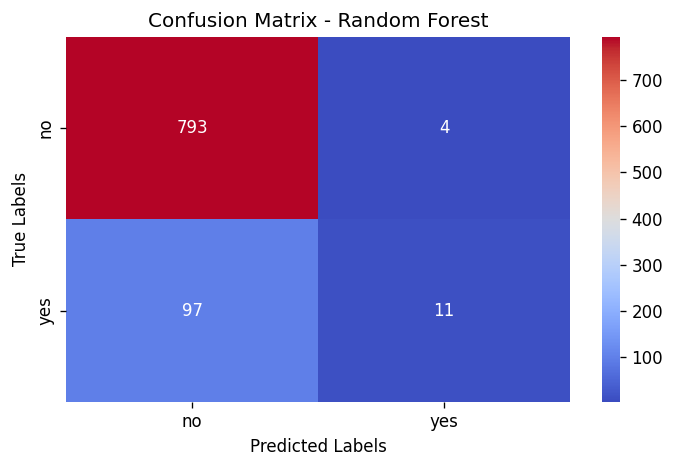

In [15]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix for Random Forest:")
rf_conf_matrix = confusion_matrix(y_test, rf_model.predict(X_test))

import seaborn as sns
import matplotlib.pyplot as plt
# Plot the confusion matrix heatmap
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=['no', 'yes'], yticklabels=['no', 'yes'], ax=ax)
ax.set_title("Confusion Matrix - Random Forest")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

plt.tight_layout()
plt.show()